# CS 436 / 536: Introduction to Machine Learning
# Fall 2024
## Neural Networks

##### This file relies upon several functions implemented previously in the notebook on Linear Models and Regularization and Validation.

##### You will have to make several modifications throughout to adapt this code to the homework problems. Please thoroughly check each and every code block to make sure it is performing exactly the function you need it to perform

In [ ]:
!pip install ipynb
from tqdm import tqdm # optional to track progress

from ipynb.fs.full.LinearModels import *
from ipynb.fs.full.RegularizationValidation import *
# from ipynb.fs.full.Similarity import *

In [2]:
'''
Init

This is a HACK!
'''

execute = True
execute

True

## Read MNIST Digits Dataset

In [3]:
'''
Read training and test datasets
'''
if execute:
    Xdigitstrain, ydigitstrain = readData('ZipDigits.train')

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

    print(f'Xdigitstrain shape {Xdigitstrain.shape}, ydigitstrain shape {ydigitstrain.shape}')

X shape: (7291, 256)
y shape: (7291, 1)
Xdigitstrain shape (7291, 256), ydigitstrain shape (7291, 1)


In [4]:
if execute:
    Xdigitstest, ydigitstest = readData('ZipDigits.test')

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

    print(f'Xdigitstest shape {Xdigitstest.shape}, ydigitstest shape {ydigitstest.shape}')

X shape: (2007, 256)
y shape: (2007, 1)
Xdigitstest shape (2007, 256), ydigitstest shape (2007, 1)


## Feature Normalization

### Compute 'Augmented' Feature Matrix

In [5]:
if execute:
    print('Computing augmented training feature matrix')

    Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

    Naugtrain, d = Xaugtrain.shape

    print(f'Xaugtrain shape {Xaugtrain.shape}')

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Xaugtrain shape (7291, 3)


In [6]:
if execute:
    print('Computing augmented test feature matrix')

    Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

    Naugtest, d = Xaugtest.shape

    print(f'Xaugtest shape {Xaugtest.shape}')

Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)
Xaugtest shape (2007, 3)


### Combine Data

In [7]:
if execute:
    Xaug = np.concatenate((Xaugtrain, Xaugtest), axis=0)
    Naug, d = Xaug.shape
    ycombined = np.concatenate((ydigitstrain, ydigitstest), axis=0)

    assert(Xaug.shape[0] == Ndigitstrain + Ndigitstest)
    assert(ycombined.shape[0] == Ndigitstrain + Ndigitstest)

    print(f'Xaug shape {Xaug.shape}, ycombined shape {ycombined.shape}')

Xaug shape (9298, 3), ycombined shape (9298, 1)


### Normalize Features

In [8]:
if execute:
    Xnorm = normalize(Xaug)
    N, d = Xnorm.shape
    print(Xnorm.shape)

    assert(Xnorm.shape == Xaug.shape)
    assert(np.all( Xnorm[:, 0] == np.ones((N, 1)) ))

(9298, 3)


### Setup Labels for the 1s vs Non 1s Classification Task

In [9]:
if execute:
    for n in range(N):
        if ycombined[n, 0] == 1:
            ycombined[n, 0] = 1
        else:
            ycombined[n, 0] = -1

## Train-Test Split

### Randomly select $K$ data points from the input data

In [10]:
if execute:
    Xin, yin, Xtest, ytest = splitDataSelectKRandomly(Xnorm, ycombined, 100)

    print(f'Xnorm shape {Xnorm.shape} ycombined shape {ycombined.shape}\n\
    X shape {Xin.shape} y shape {yin.shape}\n\
    Xtest shape {Xtest.shape}, ytest shape {ytest.shape}')

Xnorm shape (9298, 3) ycombined shape (9298, 1)
    X shape (100, 3) y shape (100, 1)
    Xtest shape (9198, 3), ytest shape (9198, 1)


### Visualize the Data

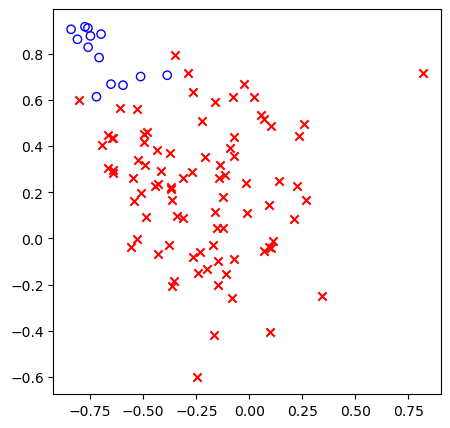

In [11]:
if execute:
    fig, axs = plt.subplots(figsize=(5, 5))
    plus1s = np.where(yin == 1)[0]
    minus1s = np.where(yin == -1)[0]
    Xplus1s = Xin[plus1s, :]
    Xminus1s = Xin[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')

## Neural Networks

### Transformation Functions

- linear / identity: $\theta(s)=s$
- tanh: $\theta(s)=\tanh(s)$
- sign: $\theta(s)=sign(s)$

In [12]:
def tanh(s):
    return np.tanh(s)

def sign(s):
    return np.sign(s)

def identity(s):
    return s

### Architecture Specification

In [13]:
d = [2, 2, 1]

#### Initializing Weights matrix

In [14]:
def init_weights(d):
    L = len(d)
    W = [None]
    for l in range(1, L):
        W.append(np.random.rand(1+d[l-1], d[l]))
        # W.append(np.zeros((1+d[l-1], d[l])) + 0.1)
        # print(f'layer {l} weights matrix has shape {W[l].shape}')
    return W

In [15]:
W = init_weights(d)

### Forward Propagation to Compute $h(x)$ Defined by Weights $w$ of a Neural Network

$h(x)=x^{(L)}$, where 

$x^{(0)}=x$, $x$ being the input data point

and for each $l=1,\dots,L$, $x^{(l)}=\begin{bmatrix}1\\ \theta(s^{(l)})\\\end{bmatrix}$ and $s^{(l)}=(W^{(l)})^T x^{(l-1)}$

In [16]:
def forwardNN(d, W, x, output_transform='tanh'):
    '''
    Input:
        d: list of L (no. of layers) integers specifying the neural network architecture
        W: list of weight matrices
           W[0]=None No weights for input layer, i.e., 0-th layer
           for layer l = 1, ..., L:
               W[l] is a 1+d[l-1] x d[l] 2D numpy array of real numbers
               representing the weights for the l-th layer
        x: an input data point, a d[0] x 1 2D numpy array
        output_transform: 'tanh' or 'sign', a string
    Output:
        S: list of length L
           S[0] = None
           for layer l = 1, ..., L:
               S[l] is a d[l] x 1 2D numpy array of real numbers
               representing the linear signal at the nodes of layer l
        X: list of length L
           X[0] = input x
           for layer l = 1, ..., L:
               X[l] is a 1 + d[l] x 1 2D numpy array of real numbers
               representing the outputs of the nodes of layer l
            X[L-1][1:, :] is the d[L] x 1 output of the hypothesis (neural network) 
            defined by weights in input W on data point x
    '''
    L = len(d)
    # print(f'layers {L}')
    assert(x.shape == (d[0]+1, 1))
    X = [] # Outputs of each layer 
    S = [None] # inputs to each layer
    '''
    Initialization
    '''
    X.append(x)
    '''
    Forward propagation
    '''
    for l in range(1, L):
        '''
        TODO:
        Compute linear signals at layer l
        Sl = ?
        S.append(Sl)
        assert(S[l].shape == (d[l], 1)) # always be checking dimensionality
        '''
 

        '''
        TODO:
        Apply theta transformation to compute outputs of layer l
        You must be careful to allow the user to specify both the tanh and sign activation functions for the final layer
        Xl = ? # may need a few more lines of code
        X.append(Xl)
        assert(X[l].shape == (1+d[l], 1)) # always be checking dimensionality
        '''

    return S, X

In [17]:
d = [2, 2, 1]
L = len(d)

W1 = np.array([[0.25, 0.25], [0.25, 0.25], [0.25, 0.25]])
W2 = np.array([[0.25], [0.25], [0.25]])
W = [None, W1, W2]

x = np.zeros((3, 1))
x[0, 0] = 1
x[1, 0] = 1
x[2, 0] = 2
y = 1

S, X = forwardNN(d, W, x)

for l in range(L):
    print(f'layer {l}')
    print(f'linear signal S[{l}]')
    print(S[l])
    print(f'output X[{l}]')
    print(X[l])

layer 0
linear signal S[0]
None
output X[0]
[[1.]
 [1.]
 [2.]]
layer 1
linear signal S[1]
[[1.]
 [1.]]
output X[1]
[[1.        ]
 [0.76159416]
 [0.76159416]]
layer 2
linear signal S[2]
[[0.63079708]]
output X[2]
[[1.        ]
 [0.55860082]]


 ### Computing Error $E_{\text{in}}(w)$
 
 $E_{\text{in}}(w)=E_{\text{in}}(h)=\frac{1}{N}\sum_{n=1}^{N}(h(x)-y)^2$
 
 where $h(x)$ is the Neural Network hypothesis function defined by weights $w$.

In [18]:
def computeError(d, W, Xin, yin):
    '''
    Input:
        d: list of L (no. of layers) integers specifying the neural network architecture
        W: list of weight matrices
           W[0]=None No weights for input layer, i.e., 0-th layer
           for layer l = 1, ..., L:
               W[l] is a 1+d[l-1] x d[l] 2D numpy array of real numbers
               representing the weights for the l-th layer
        Xin: an N x d[0] 2D numpy array of input data points
        yin: an N x 1 2D numpy array of labels of data points in Xin
    Output:
        Ein: In-sample error of NN with weights W on dataset with data points Xin and labels yin
    '''
    L = len(d)
    N, din = Xin.shape
    assert(din == d[0]+1)
    Ein = 0
    for n in range(N):
        xn = Xin[n, :].T
        xn = np.reshape(xn, (din, 1))
        yn = yin[n, 0]
        '''
        Forward propagation
        '''
        S, X = forwardNN(d, W, xn)
        yhat = X[L-1][1, 0]
        # print(n, yn, yhat)
        Ein += (1/N)*((yhat - yn)**2)
    return Ein

### Compute Gradient $\nabla E_{\text{in}}(w)$ Using Finite Difference Method


At a data point $x$,

$\frac{\partial e(x)}{\partial W_{ij}^{(l)}}=\frac{e(x | W_{ij}^{(l)} + \Delta) - e(x | W_{ij}^{(l)} - \Delta)}{2\Delta}$

where 

$e(x|w) = (h(x)-y)^2$, is the error of the $h$ is the neural network hypothesis function defined by weights $w$ on data point $x$, 

$W_{ij}^{(l)}$ is the weight on the edge of the neural network connecting the $i$-th node in layer $l-1$ to the $j$-th node in layer $l$,

$e(x|W_{ij}^{(l)}+c)$ is the error of the $h$ is the neural network hypothesis function when $W_{ij}^{(l)}$ is perturbed by a constant $c$ and the remaining weights are unchanged and as specified in $w$ on data point $x$, 

$y$ is the label associated with data point $x$, and

$\Delta$ is a small constant

In [19]:
def computeGradientNumerical(d, W, Xin, yin, tol=10**-6):
    L = len(d)
    N, din = Xin.shape
    G = [None] + [np.zeros((1+d[l-1], d[l])) for l in range(1, L)]
    for n in range(N):
        for l in range(1, L):
            for i in range(1+d[l-1]):
                for j in range(d[l]):
                    x = (Xin[n, :].T).reshape((din, 1))
                    y = yin[n, 0]
                    W_plus_tol = W
                    W_plus_tol[l][i, j] += tol
                    S, X = forwardNN(d, W_plus_tol, x, output_transform='tanh')
                    yhat = X[L-1][1, 0]
                    e_W_plus_tol = (1/N)*((yhat - y)**2)
                    W_minus_tol = W
                    W_minus_tol[l][i, j] -= tol
                    S, X = forwardNN(d, W_minus_tol, x, output_transform='tanh')
                    yhat = X[L-1][1, 0]
                    e_W_minus_tol = (1/N)*((yhat - y)**2)
                    grad = (e_W_plus_tol - e_W_minus_tol) / (2 * tol)
                    G[l][i, j] += grad
    return G

### Compute Gradient $\nabla E_{\text{in}}(w)$ Using Backpropagation

$\frac{\partial e(x)}{\partial W^{(l)}}=x^{(l-1)}(\delta^{(l)})^T$,

- where $\delta^{(l)}=\theta'(s^{(l)})\odot[W^{(l+1)}\delta^{(l+1)}]_1^{d^{(l)}}$, 

    - where $\theta'(s^{(l)})=[1-x^{(l)}\odot x^{(l)}]_1^{d^{(l)}}$, and

- $\delta^{(L)}=2(x^{(L)}-y)\theta'(s^{(L)})$, where $\theta'(s^{(L)})=1-(x^{(L)})^2$

TODO:
- Implement the algorithm to compute the gradient using backpropagation in two steps below

#### Compute Sensitivities using Backpropagation

$\delta^{(l)}=\theta'(s^{(l)})\odot[W^{(l+1)}\delta^{(l+1)}]_1^{d^{(l)}}$

$\delta^{(L)}=2(x^{(L)}-y)\theta'(s^{(L)})$, where $\theta'(s^{(L)})=1-(x^{(L)})^2$

TODO:
- Implement the backpropagation algorithm to compute the sensitivities of the error to the linear signal at each layer

In [20]:
def backwardNNsensitivity(d, W, x, y, output_transform='tanh'):
    '''
    Input:
        d: list of L (no. of layers) integers specifying the neural network architecture
        W: list of weight matrices
           W[0]=None No weights for input layer, i.e., 0-th layer
           for layer l = 1, ..., L:
               W[l] is a 1+d[l-1] x d[l] 2D numpy array of real numbers
               representing the weights for the l-th layer
        x: an input data point, a d[0] x 1 2D numpy array
        y: label of input data point x, a real number
        output_transform: 'tanh' or 'sign', a string
    Output:
        deltas: list of sensitivities of the error to the linear signals at each layer
                for layer l = 1, ..., L:
                    deltas[l] is a d[l] x 1 2D numpy array
    '''
    L = len(d)
    # print(f'layers {L}')
    S, X = forwardNN(d, W, x) # forward propagation
    deltas = [None] + [np.zeros((d[l], 1)) for l in range(1, L)]
    '''
    Initialization
    TODO:
    thetaprime = 1
    if output_transform == 'tanh':
        thetaprime = ?
    assert(thetaprime.shape == (d[L-1], 1)) # always be checking dimensionality
    deltas[L-1] = (?*thetaprime).reshape((1, 1))
    assert(deltas[L-1].shape == (d[L-1], 1)) # always be checking dimensionality
    '''

    
    '''
    Backpropagation
    '''
    for l in range(L-2, 0, -1):
        # print(f'layer {l} of {L-1}')
        '''
        Compute sensitivity at layer l
        TODO:
        thetaprime = ?
        assert(thetaprime.shape == (d[l], 1)) # always be checking dimensionality
        deltas[l] = ?
        assert(deltas[l].shape == (d[l], 1)) # always be checking dimensionality
        '''

    return deltas

#### Computing the Gradient $\nabla E_{\text{in}}(w)$

$\frac{\partial e(x)}{\partial W^{(l)}}=x^{(l-1)}(\delta^{(l)})^T$

TODO:
- Implement the algorithm to compute the gradient using backpropagation

In [21]:
def computeGradientBackpropagation(d, W, Xin, yin):
    '''
    Input:
        d: list of L (no. of layers) integers specifying the neural network architecture
        W: list of weight matrices
           W[0]=None No weights for input layer, i.e., 0-th layer
           for layer l = 1, ..., L:
               W[l] is a 1+d[l-1] x d[l] 2D numpy array of real numbers
               representing the weights for the l-th layer
        Xin: an N x d[0] 2D numpy array of input data points
        yin: an N x 1 2D numpy array of labels of data points in Xin
    Output:
        Ein: In-sample error of NN with weights W on dataset with data points Xin and labels yin
        G: list of gradients for each layer
            G[0]=None
            for layer l = 1, ..., L:
                G[l] is a 1+d[l-1] x d[l] 2D numpy array of partial derivatives of e w.r.t. W[l]
    '''
    L = len(d)
    N, din = Xin.shape
    assert(din == d[0]+1)
    '''
    Initialization
    '''
    Ein = 0
    G = [None] + [np.zeros((1+d[l-1], d[l])) for l in range(1, L)]
    for n in range(N):
        # print(f'data point {n}')
        '''
        Read in the data point
        '''
        xn = Xin[n, :].T
        xn = np.reshape(xn, (din, 1))
        yn = yin[n, 0]
        '''
        Forward propagation
        TODO: Use it
        '''
    
    
        '''
        Backward propagation
        TODO: Use it
        '''
          
            
        '''
        TODO:
        Compute Ein
        '''
 

        '''
        TODO:
        Compute gradients
        
        for l in range(1, L):
            # print(f'layer {l} of {L-1}')
            G_l_xn = ?
            G[l] += ?
        '''
        
    return Ein, G

### Test

The directions of the gradient "vector" must be nearly identical, even if their magnitudes are off by a factor of 2 using the two different methods.

In [22]:
d = [2, 2, 1]
L = len(d)

W1 = np.array([[0.25, 0.25], [0.25, 0.25], [0.25, 0.25]])
W2 = np.array([[0.25], [0.25], [0.25]])
W = [None, W1, W2]

x = np.zeros((3, 1))
x[0, 0] = 1
x[1, 0] = 1
x[2, 0] = 2
y = 1

Xexp = (x.T).reshape((1, 3))
yexp = np.array(y).reshape((1, 1))


Gnumerical = computeGradientNumerical(d, W, Xexp, yexp)
Ein, Gbackprop = computeGradientBackpropagation(d, W, Xexp, yexp)

for l in range(1, L):
    print(f'layer {l}')
    print(W[l])
    print(f'gradient using numerical G[{l}] / ||G[{l}]||')
    print(Gnumerical[l]/np.linalg.norm(Gnumerical[l]))
    print(f'gradient using backpropagation G[{l}] / ||G[{l}]||')
    print(Gbackprop[l]/np.linalg.norm(Gbackprop[l]))

layer 1
[[0.25 0.25]
 [0.25 0.25]
 [0.25 0.25]]
gradient using numerical G[1] / ||G[1]||
[[-0.28867531 -0.28867531]
 [-0.28867531 -0.28867531]
 [-0.5773501  -0.5773501 ]]
gradient using backpropagation G[1] / ||G[1]||
[[-0.28867513 -0.28867513]
 [-0.28867513 -0.28867513]
 [-0.57735027 -0.57735027]]
layer 2
[[0.25]
 [0.25]
 [0.25]]
gradient using numerical G[2] / ||G[2]||
[[-0.68040562]
 [-0.51819311]
 [-0.51819311]]
gradient using backpropagation G[2] / ||G[2]||
[[-0.68040574]
 [-0.51819303]
 [-0.51819303]]


### Batch Gradient Descent to Fit Data

In each iteration,
- Compute gradient of the error function with current weights $w$ on the full training data set $Xin$
- Update the weights $w(t+1)\gets w(t)-\eta\nabla E_{\text{in}}(w(t))$

TODO:
- Implement variable learning rate to set $\eta$
- Implement early stopping as a regularization measure to prevent overfitting

In [23]:
def batchGradientDescent(d, Xin, yin, eta=0.01, alpha=1, beta=1, max_iters=10**6, W=None, weight_decay=0):
    L = len(d)
    N, din = Xin.shape
    '''
    TODO:
    Implement early stopping using a validation set
    '''
    Eins = []
    if None == W:
        W = init_weights(d)
    iteration = 0
    while(1):
        if iteration >= max_iters:
            break
        # print(f'iteration {i}')
        '''
        TODO:
        Compute Ein before update at current weights W on all N data points
        Ein_W = computeError(?)
        '''
        Ein_W = None


        '''
        TODO:
        Compute gradient using backpropagation
        Ein, G = computeGradientBackpropagation(?)
        '''
        
        
        '''
        TODO: Compute updated weights
        Wtmp - represents the weights for each layer temporarily for this iteration
        '''
        Wtmp = [None]

        '''
        Compute Ein after update at Wtmp on all N data points
        '''    
        Ein_Wtmp = computeError(d, Wtmp, Xin, yin)
        if Ein_Wtmp < Ein_W:
            '''
            Lowered in sample error
            TODO: 
            W = ?
            eta = ?
            '''

        else:
            '''
            Bad update
            W = ?
            eta = ?
            '''

        iteration += 1
    '''
    Plot the progress made
    '''
    plt.plot(range(max_iters), Eins)
    plt.xlabel('# iterations')
    plt.ylabel('Ein')
    
    return W

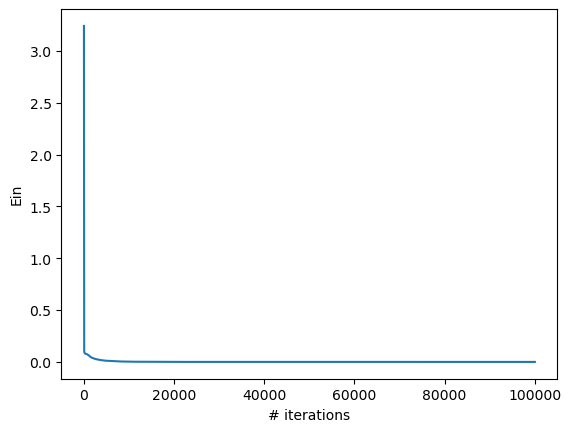

In [39]:
# architecture
d = [2, 10, 1]
W = batchGradientDescent(d, Xin, yin, eta=0.1, alpha=1.1, beta=0.8, max_iters=10**5)

In [45]:
# Compute W once again with Batch gradient descent with updated weights from previous cell
W = batchGradientDescent(d, Xin, yin, eta=1, alpha=1.1, beta=0.8, max_iters=10**5, W=W)

In [46]:
# print(W)

[None, array([[-1.04573424, -0.92408899,  1.29457256,  2.03829914,  1.57799363,
         5.74056613, -1.60027145,  1.45288424, -2.91388968, -8.53961708],
       [ 4.0788007 , 12.67087973, -0.03471024, -0.03985431, -0.33053512,
         8.40262122,  2.71626322,  0.07209433, -0.45847925,  3.94727051],
       [ 6.85875066,  7.49264488,  1.10852226,  0.31822328,  0.80687136,
        -1.62761279,  5.93663934,  0.85881514,  0.90621062, 18.82296578]]), array([[ -4.84084872],
       [  6.22017249],
       [-14.41029304],
       [ -2.30810614],
       [ -3.91669817],
       [ -3.20476916],
       [-10.1201748 ],
       [  4.95463573],
       [ -2.37353426],
       [  5.55533816],
       [ 20.28743973]])]


#### Make predictions

In [41]:
def predictClassNN(d, W, Xtest):
    '''
    Predict class using Neural Network
    Input:
        d: list of L (no. of layers) integers specifying the neural network architecture
        W: list of weight matrices
           W[0]=None No weights for input layer, i.e., 0-th layer
           for layer l = 1, ..., L:
               W[l] is a 1+d[l-1] x d[l] 2D numpy array of real numbers
               representing the weights for the l-th layer
        Xin: an N x d[0] 2D numpy array of input data points
        
    Output:
        ytest: a 2D Ntest x 1 anumpy array of predicted classes of examples in Xtest
    '''
    N, dtest = Xtest.shape
    yhat = np.zeros((N, 1))
    for n in range(N):
        xtest = Xtest[n, :].reshape((dtest, 1))
        assert(xtest.shape == (d[0]+1, 1))
        S, X = forwardNN(d, W, xtest, output_transform='sign')
        yhat[n, 0] = X[L-1][1, 0]
    return yhat

#### Plot decision boundary

In [37]:
def plotNNSeparator(X, y, d, W, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by the k Nearest Neighbors Algorithm
    Input:
        X: a 2 dimensional N x d numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0], ..., X[n, d-1] have values of features
        y: a 2 dimensional N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        k: positive integer
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(10, 10))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 1, 250)
    pltx2s = np.linspace(-1, 1, 250)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    pltyhat = predictClassNN(d, W, pltX)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='Not 1')
    '''
    Finishing touches
    '''
    axs.set_xlim(-1, 1)
    axs.set_ylim(-1, 1)
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title(title)
    axs.legend()
    plt.show()

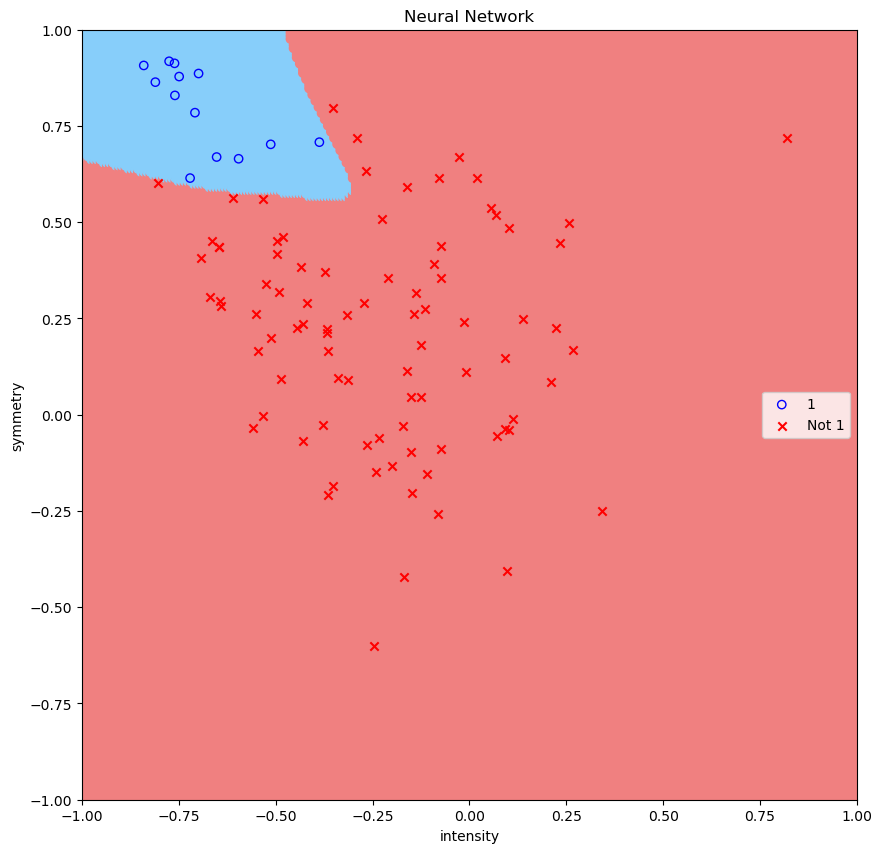

In [43]:
# The below is the plot for training data. Please complete the plot for testing data as well.
plotNNSeparator(Xin, yin, d, W, title=f'Neural Network')

In [ ]:
'''
Using lamda for weight decay
lamda = ?
'''

lamda = None
W = batchGradientDescent(d, Xin, yin, eta=0.1, alpha=1.1, beta=0.8, max_iters=2 * 10**5, weight_decay=lamda)

In [ ]:
'''
Plot for training and testing data as well
'''

plotNNSeparator(Xin, yin, d, W, title=f'Neural Network')

In [ ]:
'''
Can run batch gradient descent for reduced number of iterations for Early stopping.
'''